In [233]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import numpy as np

gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    n_restarts_optimizer=2,
    alpha=0.0000001,
    random_state=2)

f = lambda x: (x+0.5)**2

def rosenbrock(x):
    return sum((x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)
        
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

f = rosenbrock

X = np.array([np.random.uniform([2., 2., 2]) for x in range(30)])
Y = [f(x) for x in X]
Ymean = np.mean(Y)
Ystddev = np.std(Y)
Ynorm = (Y-Ymean)/Ystddev
gp.fit(X, Ynorm)

GaussianProcessRegressor(alpha=1e-07, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=2.5), n_restarts_optimizer=2,
             normalize_y=False, optimizer='fmin_l_bfgs_b', random_state=2)

[ 1.52706054  1.01345289  1.18789701  1.54785226  1.05018462  1.88157127
  1.44528268  1.94004975  1.27204518  1.71043269]
0.0440970433553


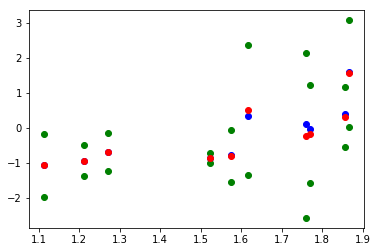

In [234]:


x = np.array([np.random.uniform([2., 2., 2.]) for x in range(10)])

y_pred, y_std = gp.predict(x, return_std=True)
y_f = f(x.T)
y_fNorm = (y_f - Ymean)/Ystddev

print(x[:,2])
#print(np.shape(y_f))
plt.plot(x[:,1], y_fNorm, 'bo')
plt.plot(x[:,1], y_pred + (10*y_std), 'go')
plt.plot(x[:,1], y_pred - (10*y_std), 'go')
plt.plot(x[:,1], y_pred, 'ro')

print(y_std[1])


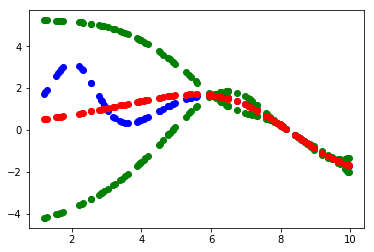

In [300]:
import math

gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    n_restarts_optimizer=2,
    alpha=0.0000001,
    random_state=2)

f = lambda x: (x+0.5)**2+np.random.uniform()
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)
f=target

X = test_x = np.array([np.random.uniform([10.]) for x in range(5)])

Y = [f(x) for x in X]
Ymean = np.mean(Y)
Ystddev = np.std(Y)
Ynorm = (Y-Ymean)/Ystddev
gp.fit(X, Ynorm)
gp.fit(X, Ynorm)

test_x = np.array([np.random.uniform([10.]) for x in range(100)])
#print(test_x)
y_pred, y_std = gp.predict(test_x, return_std=True)
y_f = f(test_x)
y_fNorm = (y_f - Ymean)/Ystddev
#print y_pred
#print(np.shape(y_f))
kappa = 5
plt.plot(test_x, y_fNorm, 'bo')
plt.plot(test_x, y_pred.flatten() + (kappa*y_std), 'go')
plt.plot(test_x, y_pred.flatten() - (kappa*y_std), 'go')
plt.plot(test_x, y_pred, 'ro')


In [266]:
np.random.uniform()

0.08906527824694865

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in divide


(array([ 3.61118737]), 0.99411382908604007)

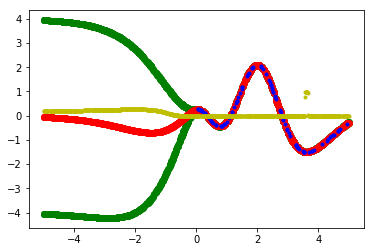

In [445]:
def fit_normalized_gaussian_process(X, y, nu=2.5):
    gp = GaussianProcessRegressor(
        kernel=Matern(nu=nu),
        n_restarts_optimizer=2,
        alpha=0.0000001,
        random_state=2)
    
    y_mean = np.mean(y)
    y_stddev = np.std(y)
    y_norm = (y-y_mean)/y_stddev

    gp.fit(X, y_norm)
    return gp, y_mean, y_stddev

def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def next_sample(sample_X, sample_y, X_bounds, current_X=None, kappa=4, nu=2.5, max_samples=100):
    """
        Check out https://www.iro.umontreal.ca/~bengioy/cifar/NCAP2014-summerschool/slides/Ryan_adams_140814_bayesopt_ncap.pdf
         for explanation of bayesian optimization
         
        nu - input to the Matern function, higher numbers make it smoother 0.5, 1.5, 2.5 are good values
             see http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html
        kappa - number of standard deviations to look at - higher means explore more, lower means exploit more
        sample_X - vector of already evaluated sets of hyperparameters
        sample_y - vector of already evaluated loss function values
        current_X - hyperparameters currently being explored
        max_samples - maximum samples to consider (since algo is O(n^3)) for performance, but also adds some randomness
        X_bounds - minimum and maximum values for every dimension of X
    """
    
    sample_X = np.array(sample_X)
    sample_y = np.array(sample_y)
    
    if kappa < 2:
        raise ValueError("Kappa must be at least 2")
    
    if len(np.array(sample_X).shape) != 2:
        raise ValueError("Sample X must be a 2 dimensional array")
    
    num_hyperparameters = sample_X.shape[1]
    
    if current_X != None:
        current_X = np.array(current_X)
        if len(current_X.shape) != 2:
            raise ValueError("Current X must be a 2 dimensional array")
            
        # we can't let the current samples be bigger than max samples
        # because we need to use some real samples to build the curve
        if current_X.shape[0] > max_samples - 5:
            print("current_X is bigger than max samples - 5 so dropping some currently running parameters")
            current_X = current_X[(max_samples-5), :]
        
    if len(sample_y.shape) != 1:
        raise ValueError("Sample y must be a 1 dimensional array")    
    
    if sample_X.shape[0] != sample_y.shape[0]:
        raise ValueError("Sample X and sample y must be the same size")    

    if sample_X.shape[1] != len(X_bounds):
        raise ValueError("Bounds must be the same length as Sample X's second dimension")
        
    if sample_X.shape[0] > max_samples:
        sample_indices = np.random.randint(sample_X.shape[0], size=max_samples)
        X = sample_X[sample_indices]
        y = sample_y[sample_indices]
    else:
        X = sample_X
        y = sample_y
        
    gp, y_mean, y_stddev = fit_normalized_gaussian_process(X,y)
    
    if current_X != None:
        # if we have some hyperparameters running, we pretend that they return
        # the prediction of the function we've fit
        X = np.append(X, current_X, axis=0)
        
        current_y_fantasy = (gp.predict(current_X)*y_stddev)+y_mean
        y = np.append(y, current_y_fantasy)
     
        gp, y_mean, y_stddev = fit_normalized_gaussian_process(X,y)
        
    num_test_samples = 1000
    
    # Look for the minimum value of our fitted-target-function + (kappa * fitted-target-std_dev)
    test_X = np.empty((num_test_samples, num_hyperparameters))
    
    for ii in range(num_test_samples):
        for jj in range(num_hyperparameters):
            if type(X_bounds[jj][0]) == int:
                assert(type(X_bounds[jj][1]) == int)
                test_X[ii,jj] = np.random.randint(X_bounds[jj][0],X_bounds[jj][1])
            else:
                test_X[ii,jj] = np.random.uniform() * (X_bounds[jj][1] - X_bounds[jj][0]) + X_bounds[jj][0]

    y_pred, y_std = gp.predict(test_X, return_std=True)
    
    # this would be the lowest score for a given kappa
    # best_test_X_index = np.argmin(y_pred-kappa*y_std)
    
    #best chance of an improvement
    improvement = 0.001
    norm_improvement = improvement/y_stddev
    min_norm_y = (np.min(y)-y_mean)/y_stddev # best value of y in our sample data
    y_best=min_norm_y-norm_improvement
    distance = (y_pred-y_best)
    std_dev_distance = (y_pred-y_best)/y_std
    
    prob_of_improve = sigmoid(-std_dev_distance)
    best_test_X_index = np.argmax(prob_of_improve)
    
    debug_plot = True
    if debug_plot:
        plt.plot(test_X[:,0], y_pred + (kappa*y_std), 'go')
        plt.plot(test_X[:,0], y_pred - (kappa*y_std), 'go')
        plt.plot(test_X[:,0], y_pred, 'ro')
        plt.plot(X[:,0], ((y-y_mean)/y_stddev), 'b.')
        plt.plot(test_X[:,0],np.clip(prob_of_improve, -100, 100.), 'y.')
        #plt.plot(test_X[:,0], y_std*100, 'y.')


    return test_X[best_test_X_index], prob_of_improve[best_test_X_index]
        
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

X = np.append(
    np.array([np.random.uniform([0.], [5.]) for x in range(100)]),
    np.array([np.random.uniform([0.], [5.]) for x in range(100)]),
    axis = 0
)

#X = np.array([np.random.uniform([5.]) for x in range(200)])
Y = np.array([f(x) for x in X]).flatten()
next_sample(X, Y, [[-5., 5.]],max_samples=100)
#next_sample([[1.],[2.],[3.]],[1.,4.,9.],[[1.,10.]], current_X=[[10.]])

In [450]:
target(3.5)

0.71613235119406216

In [297]:
np.append(np.array([[1,2], [2,3]]),(np.array([[4,5],[6,7]])), axis=0)


array([[1, 2],
       [2, 3],
       [4, 5],
       [6, 7]])

In [452]:
[[1.,3.]]*10

[[1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0],
 [1.0, 3.0]]

In [453]:
np.random.uniform(2.0)

1.2911340918819019

In [457]:
[] == None


False